In [3]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from scipy.stats import norm

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,  OrdinalEncoder #### ORDINAL
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# select and train model
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

In [4]:
REP_DATA = Path('data')
REP_DATA.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile('house-prices-advanced-regression-techniques.zip', 'r') as zip_f:
    zip_f.extractall(REP_DATA)

In [5]:
df = pd.read_csv(
    REP_DATA / 'train.csv'
)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [7]:
# purge column with more than x % of NaN values
df = df.loc[:, df.isnull().mean().sort_values(ascending=False) < .2]

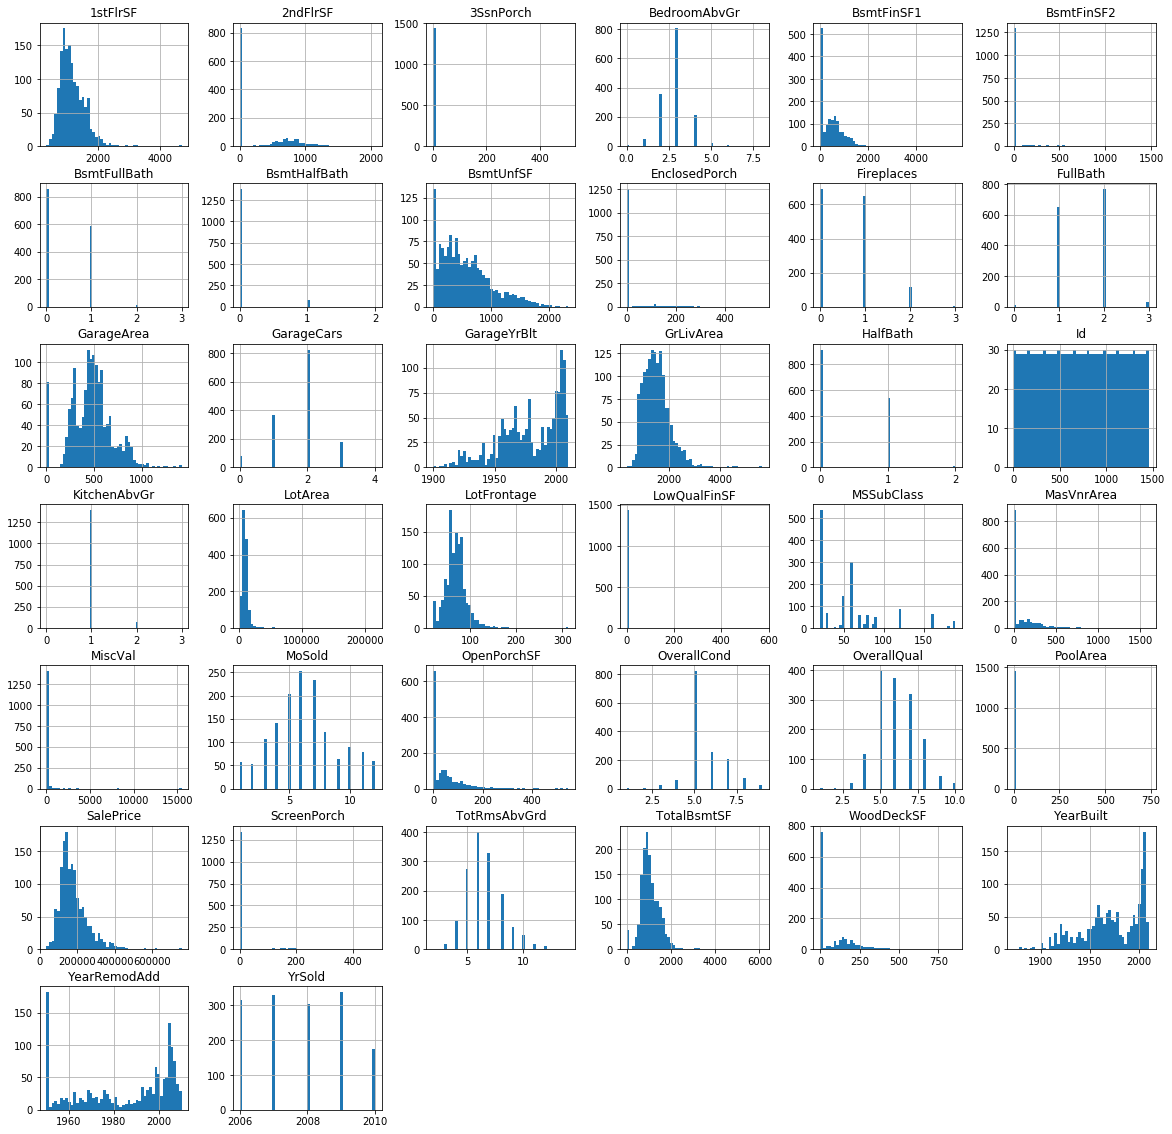

In [8]:
df.hist(bins=50, figsize=(20, 20))
plt.show()

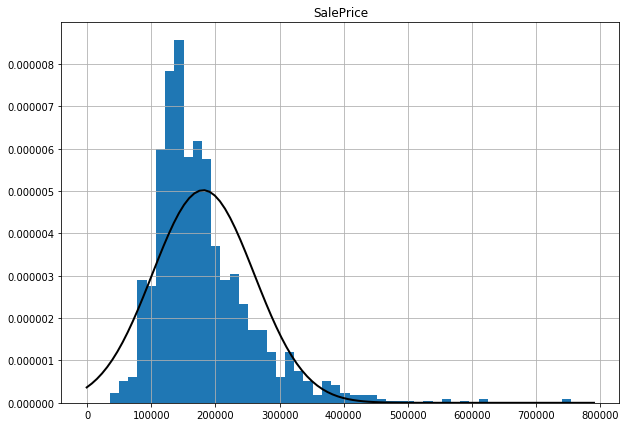

In [9]:
df[['SalePrice']].hist(bins=50, figsize=(10, 7), density=True)

# Fit a normal distribution to the data:
mu, std = norm.fit(df[['SalePrice']])
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.show()

In [10]:
# Skewness is the degree of distortion from the normal curve.
# A symmetrical distribution will have a skewness of "0". 
df['SalePrice'].skew()

1.8828757597682129

In [11]:
df['SalePrice'] = np.log(df['SalePrice'])

In [12]:
df['SalePrice'].skew()

0.12133506220520406

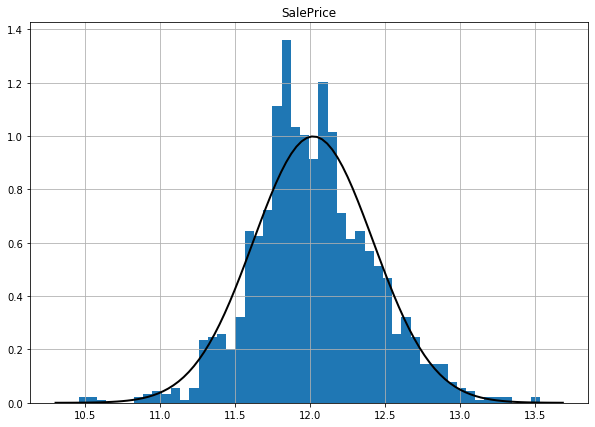

In [13]:
df[['SalePrice']].hist(bins=50, figsize=(10, 7), density=True)

# Fit a normal distribution to the data:
mu, std = norm.fit(df[['SalePrice']])
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.show()

In [14]:
df.nunique().sort_values(ascending=False)

Id              1460
LotArea         1073
GrLivArea        861
BsmtUnfSF        780
1stFlrSF         753
                ... 
BsmtHalfBath       3
PavedDrive         3
CentralAir         2
Utilities          2
Street             2
Length: 76, dtype: int64

In [15]:
df.select_dtypes('object').nunique().sort_values(ascending=False)

for c in df.select_dtypes('object'):
    df[c] = df[c].astype('category')

In [16]:
df.select_dtypes('number').nunique().sort_values(ascending=False)

Id               1460
LotArea          1073
GrLivArea         861
BsmtUnfSF         780
1stFlrSF          753
TotalBsmtSF       721
SalePrice         663
BsmtFinSF1        637
GarageArea        441
2ndFlrSF          417
MasVnrArea        327
WoodDeckSF        274
OpenPorchSF       202
BsmtFinSF2        144
EnclosedPorch     120
YearBuilt         112
LotFrontage       110
GarageYrBlt        97
ScreenPorch        76
YearRemodAdd       61
LowQualFinSF       24
MiscVal            21
3SsnPorch          20
MSSubClass         15
MoSold             12
TotRmsAbvGrd       12
OverallQual        10
OverallCond         9
PoolArea            8
BedroomAbvGr        8
YrSold              5
GarageCars          5
KitchenAbvGr        4
Fireplaces          4
BsmtFullBath        4
FullBath            4
HalfBath            3
BsmtHalfBath        3
dtype: int64

In [18]:
train_set, test_set = train_test_split(
    df,
    test_size=.2,
    random_state=24
)

X_train = train_set.copy()

In [28]:
corr_matrix = X_train.corr()
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.813141
GarageCars       0.687133
GrLivArea        0.673746
GarageArea       0.659383
TotalBsmtSF      0.602903
1stFlrSF         0.589282
FullBath         0.571411
YearBuilt        0.570300
YearRemodAdd     0.555501
GarageYrBlt      0.532133
TotRmsAbvGrd     0.515031
Fireplaces       0.500163
MasVnrArea       0.415861
BsmtFinSF1       0.368881
OpenPorchSF      0.347121
LotFrontage      0.339049
WoodDeckSF       0.314368
HalfBath         0.298791
2ndFlrSF         0.280587
LotArea          0.241061
BsmtFullBath     0.222175
BsmtUnfSF        0.213706
BedroomAbvGr     0.175849
ScreenPorch      0.120201
MoSold           0.069412
3SsnPorch        0.047201
PoolArea         0.033549
BsmtFinSF2       0.009045
BsmtHalfBath    -0.006485
YrSold          -0.016462
MiscVal         -0.020670
Id              -0.033779
LowQualFinSF    -0.052530
OverallCond     -0.053098
MSSubClass      -0.097623
EnclosedPorch   -0.148627
KitchenAbvGr    -0.166179
Name: SalePr

In [55]:
num_attribs = corr_matrix.loc[['SalePrice'], abs(corr_matrix['SalePrice']) > .3].columns
#X_train_num.columns
num_attribs = list(num_attribs)
num_attribs.remove('SalePrice')

In [56]:
# drop() creates a copy of the data and does not affect the initial df
X_train = train_set.drop(columns=['SalePrice', 'Id'])
X_labels = train_set['SalePrice']

In [57]:
#num_attribs = list(X_train.select_dtypes('number').columns)
cat_attribs = list(X_train.select_dtypes('category').columns)

In [58]:
num_attribs

['LotFrontage',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF']

In [59]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('inmputer', SimpleImputer(strategy='most_frequent')),
    ('1hot', OneHotEncoder(handle_unknown='ignore')),
])

In [60]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

X_train_prepared = full_pipeline.fit_transform(X_train)

In [61]:
forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(X_train_prepared, X_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [62]:
def display_scores(scores):
    print('Scores:', scores)
    
    if scores.std() != 0:
        print('Mean:', scores.mean())
        print('Standard deviation:', scores.std())

In [63]:
forest_scores = cross_val_score(
    forest_reg,
    X_train_prepared,
    X_labels,
    scoring='neg_mean_squared_error',
    cv=10
)

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [0.14937317 0.13547343 0.16043918 0.16728278 0.18111264 0.13453388
 0.13101006 0.19224098 0.16350946 0.15600464]
Mean: 0.1570980227629774
Standard deviation: 0.019198808816696982


In [66]:
param_grid = [
    {
        'n_estimators': [70, 80, 90, 100, 110],
        'max_features': [14, 16, 20, 26, 28, 30, 34, 38, 42]
    },
    {
        'bootstrap': [False],
        'n_estimators': [3, 10],
        'max_features': [2, 3, 4]
    },
]


grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    return_train_score=True
)

grid_search.fit(X_train_prepared, X_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [14, 16, 20, 26, 2

In [67]:
grid_search.best_params_

{'max_features': 34, 'n_estimators': 100}

In [68]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=34, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [69]:
# all evaluation scores
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.1519412156283606 {'max_features': 14, 'n_estimators': 70}
0.1530682480428641 {'max_features': 14, 'n_estimators': 80}
0.15181890196228823 {'max_features': 14, 'n_estimators': 90}
0.1530809714305678 {'max_features': 14, 'n_estimators': 100}
0.15311748434109956 {'max_features': 14, 'n_estimators': 110}
0.15252817862673962 {'max_features': 16, 'n_estimators': 70}
0.15019166726430547 {'max_features': 16, 'n_estimators': 80}
0.15256006833138006 {'max_features': 16, 'n_estimators': 90}
0.1511273500112068 {'max_features': 16, 'n_estimators': 100}
0.15141082135419143 {'max_features': 16, 'n_estimators': 110}
0.14833140361769978 {'max_features': 20, 'n_estimators': 70}
0.15034502157703744 {'max_features': 20, 'n_estimators': 80}
0.14966652289067087 {'max_features': 20, 'n_estimators': 90}
0.14821347341621674 {'max_features': 20, 'n_estimators': 100}
0.14705672673678064 {'max_features': 20, 'n_estimators': 110}
0.14629277077664382 {'max_features': 26, 'n_estimators': 70}
0.14555848237635638 {'

In [70]:
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

[1.62518490e-02 1.01915302e-01 5.72001802e-02 2.59551578e-02
 7.75489769e-03 2.04412965e-02 5.56663502e-02 3.97387503e-02
 1.20712078e-01 3.40232141e-02 1.87898759e-02 3.60236948e-02
 2.27169621e-02 7.73093185e-02 4.71642912e-02 5.98402873e-03
 9.32974394e-03 3.53267505e-03 1.96189450e-04 1.32727955e-04
 4.28100700e-03 3.77201671e-03 2.63016352e-04 2.97238784e-04
 1.35060658e-03 4.44042349e-04 2.98246479e-04 1.48738995e-03
 1.15885402e-03 6.25791642e-04 7.06298836e-04 1.01707139e-03
 1.54574545e-06 1.15267015e-05 7.56939639e-04 4.57766738e-04
 1.56354579e-04 9.46571154e-06 7.33683355e-04 1.23413268e-03
 9.80083093e-04 2.75903672e-04 1.09090156e-04 1.73987845e-05
 1.61712244e-04 2.78653925e-04 7.39859312e-04 4.07914542e-04
 2.73803453e-03 1.22122729e-03 3.15603910e-04 5.91991871e-04
 4.23529284e-04 3.24489928e-04 6.34963926e-04 3.74827646e-05
 7.35143150e-04 1.37398906e-03 1.07553625e-03 9.53249819e-04
 1.98321390e-04 3.32007626e-04 2.11269576e-04 6.55672092e-04
 2.79563037e-04 1.852482

In [71]:
#cat_encoder = full_pipeline.named_transformers_['cat']
#cat_one_hot_attribs = list(cat_encoder.categories_[0])

#sorted(zip(feature_importances, num_attribs + cat_one_hot_attribs), reverse=True)

In [72]:
final_model = grid_search.best_estimator_

X_test = test_set.drop(columns=['SalePrice'])
y_test = test_set['SalePrice'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

display_scores(final_rmse)

Scores: 0.15044189493759696


In [73]:
df_test = pd.read_csv(
    REP_DATA / 'test.csv'
)

y_test_prepared = full_pipeline.transform(df_test)
final_predictions = final_model.predict(y_test_prepared)

# no log
final_predictions = np.exp(final_predictions)



In [74]:
final_predictions

array([123811.30453409, 147832.7742795 , 178677.51104248, ...,
       145326.83858474, 118179.87530817, 241783.03545076])

In [75]:
result = pd.concat([df_test, pd.DataFrame(final_predictions, columns=['SalePrice'])], axis=1)

In [76]:
result[['Id', 'SalePrice']].to_csv('submission.csv', index=False)